In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
import numpy as np

2025-02-07 11:10:36.581945: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-07 11:10:36.598276: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-07 11:10:36.603259: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1738923037.867498  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923037.903542  230241 cuda_executor.cc:1015] succ

## learnMSA demo

In this notebook, we will fit a number of HMM models to a dataset of unaligned sequences. 
We will then use the fitted models to align the sequences and compare the results.
Moreover, we will visualize the best (according to an objective criterion) model and alignment.

*This notebook is meant to be a demo for running learnMSA in Python code. Check the readme if you want to run learnMSA from the command line.* 

Change the variables in the following cell to fit your needs.

In [1]:
# Your fasta file to align.
train_filename = "test/data/egf.fasta"

# (optional)
# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 10

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

## Run learnMSA from Python (Training + Viterbi alignment)

In [5]:
os.makedirs("tmp", exist_ok = True)

Training of 10 models on file egf.fasta
Configuration: 
{
num_models : 10
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=100

I0000 00:00:1738923182.337344  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923182.337587  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923182.337743  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923182.337939  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1738923186.338478  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923186.338729  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923186.338884  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923186.339079  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 43s - 1s/step - loss: 85.3669 - loglik: -8.0359e+01 - prior: -5.0080e+00 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 5s - 152ms/step - loss: 64.8930 - loglik: -6.3056e+01 - prior: -1.8373e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 5s - 153ms/step - loss: 63.7790 - loglik: -6.2103e+01 - prior: -1.6764e+00 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 5s - 150ms/step - loss: 63.5605 - loglik: -6.1917e+01 - prior: -1.6439e+00 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 5s - 147ms/step - loss: 63.4681 - loglik: -6.1844e+01 - prior: -1.6240e+00 - aux_loss: 0.0000e+00
Epoch 6/10
34/34 - 5s - 149ms/step - loss: 63.3614 - loglik: -6.1752e+01 - prior: -1.6093e+00 - aux_loss: 0.0000e+00
Epoch 7/10
34/34 - 5s - 147ms/step - loss: 63.2736 - loglik: -6.1672e+01 - prior: -1.6011e+00 - aux_loss: 0.0000e+00
Epoch 8/10
34/34 - 5s - 147ms/step - loss: 63.2638 - loglik: -6.1675e+01 - prior: -1.5885e+00 - aux_loss: 0.0000e+00
Epoch 9/10
34/34 - 5s - 150ms/step - loss: 63.2252 - loglik: -6.1640e+01 - pr

I0000 00:00:1738923278.823981  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923278.824235  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923278.824392  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923278.824588  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 2), (13, 3), (14, 2), (17, 1), (18, 2)]
discards model 0: []
expansions model 1: [(12, 3), (13, 4), (16, 1), (18, 2)]
discards model 1: []
expansions model 2: [(12, 3), (13, 4), (16, 1), (18, 2)]
discards model 2: []
expansions model 3: [(12, 3), (13, 4), (16, 1), (18, 2)]
discards model 3: []
expansions model 4: [(12, 9), (13, 1)]
discards model 4: []
expansions model 5: [(12, 2), (13, 3), (18, 1), (19, 2)]
discards model 5: []
expansions model 6: [(12, 2), (13, 2), (19, 1), (20, 2)]
discards model 6: []
expansions model 7: [(12, 9), (15, 3)]
discards model 7: []
expansions model 8: [(12, 2), (13, 3), (14, 1), (17, 1), (18, 2)]
discards model 8: []
expansions model 9: [(12, 2), (14, 2), (15, 2)]
discards model 9: []
Re-initialized the encoder parameters.
Fitting models of lengths [35, 34, 34, 34, 32, 34, 34, 33, 34, 34] on 7774 sequences.
Batch size= 256 Learning rate= 0.1
Using sequence weights  [1.         1.         1.         ... 0.33333334 0.14285715 0.5

I0000 00:00:1738923287.911595  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923287.911852  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923287.912009  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923287.912214  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1738923291.678127  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923291.678390  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923291.678546  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923291.678747  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

34/34 - 43s - 1s/step - loss: 63.6847 - loglik: -5.8831e+01 - prior: -4.8536e+00 - aux_loss: 0.0000e+00
Epoch 2/10
34/34 - 5s - 149ms/step - loss: 58.7206 - loglik: -5.7007e+01 - prior: -1.7139e+00 - aux_loss: 0.0000e+00
Epoch 3/10
34/34 - 5s - 150ms/step - loss: 58.4711 - loglik: -5.6976e+01 - prior: -1.4948e+00 - aux_loss: 0.0000e+00
Epoch 4/10
34/34 - 5s - 149ms/step - loss: 58.2820 - loglik: -5.6831e+01 - prior: -1.4506e+00 - aux_loss: 0.0000e+00
Epoch 5/10
34/34 - 5s - 151ms/step - loss: 58.2841 - loglik: -5.6875e+01 - prior: -1.4096e+00 - aux_loss: 0.0000e+00
Fitted model successfully.
Creating alignment model...
Successfully created alignment model.
Time for alignment: 175.6786
Likelihoods:  ['-56.8636', '-56.9001', '-56.9275', '-56.8138', '-56.9719', '-56.9432', '-56.9439', '-56.9691', '-56.9243', '-56.9308']
Mean likelihood:  -56.91881092523958
Selection criterion: AIC
Best model:  3 (0-based)


I0000 00:00:1738923362.431829  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923362.432088  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923362.432257  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923362.432454  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 1 insertion slices with famsa.
time for generating output: 4.5434
Wrote file test/data/interactive.alignment.fasta
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 186ms/step
>l=-54.97_t=0.01
............$CD.....P.....N............P.........CYN.H.G..T..CS......L.R....................-..-.....A...T.............G..........YTCSCL..-...PR......Y....T....GEH$.......................
>l=-55.56_t=0.01
............$CD.....S.....Q............P.........CRN.-.G..T..CSl.....N.T....................-..-.....N...T.............D..........YTCACF..-...PG......Y....T....GRY$.......................
>l=-45.40_t=0.01
............$CD.....S.....D............P.........CLN.G.G..T..CT......L.R....................-..S.....L...D.............S..........YSCACA..-...PG......Y....T....GQH$.......................
>l=-60.92_t=0.01
............$CD.....H.....V............T.........CLN.G.G..T..CQ......L.K....................-..T.....L...E.............D..........YTCACA..-...NG......Y....T....GER$.......................
>l=-61.53_t=0.0

/home/felix/miniforge3/envs/learnMSAdev/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices']. Received: the structure of inputs=('*', '*')
  warnings.warn(
I0000 00:00:1738923375.779884  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923375.780124  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738923375.780289  230241 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but the

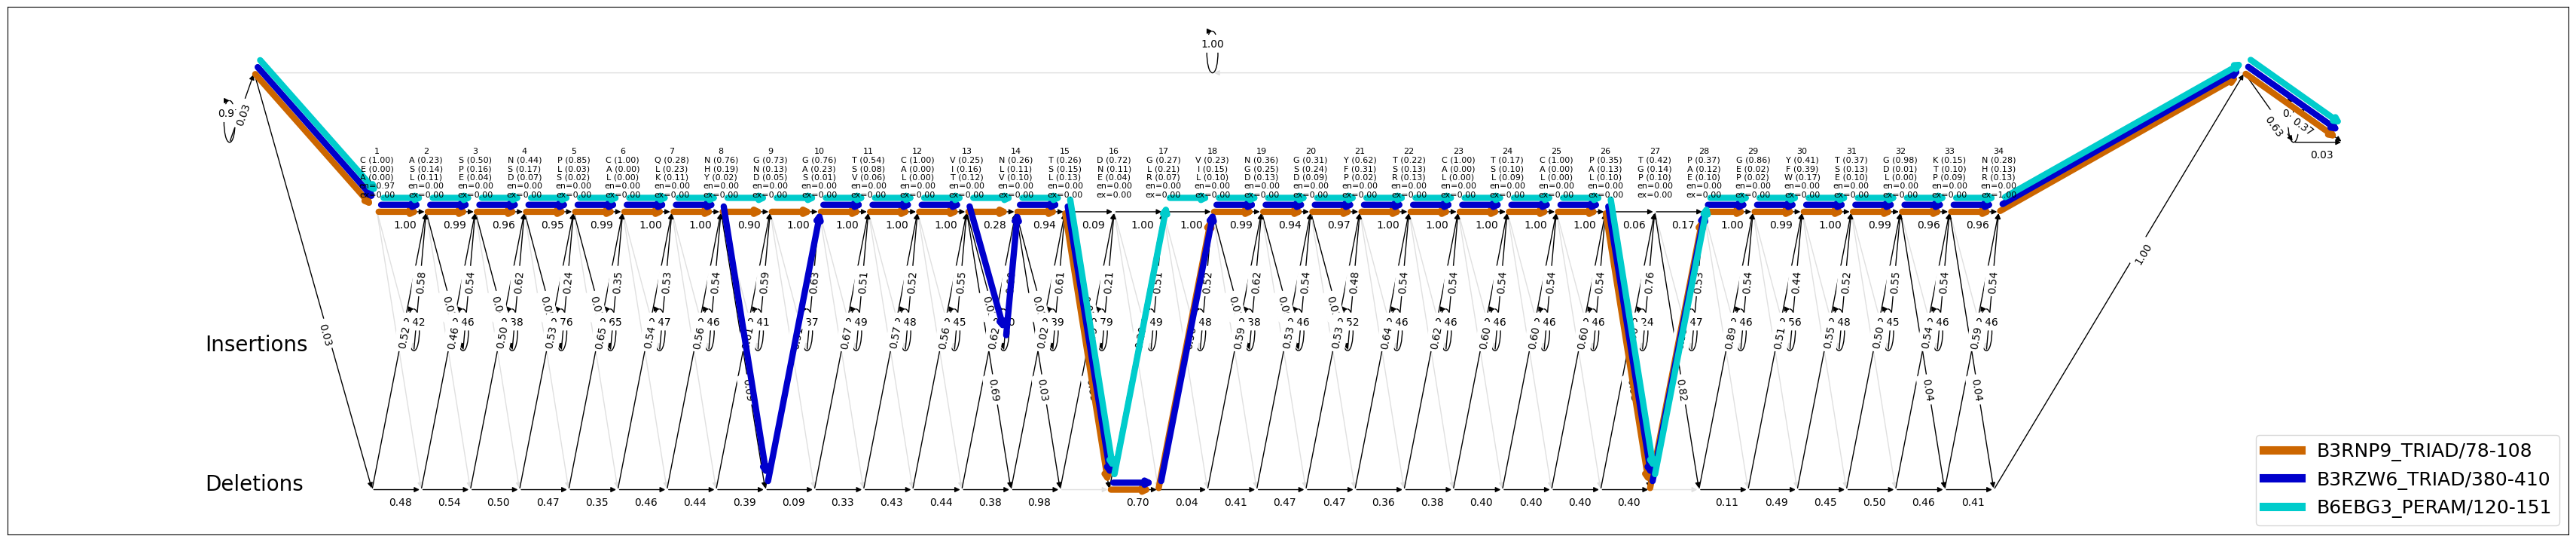

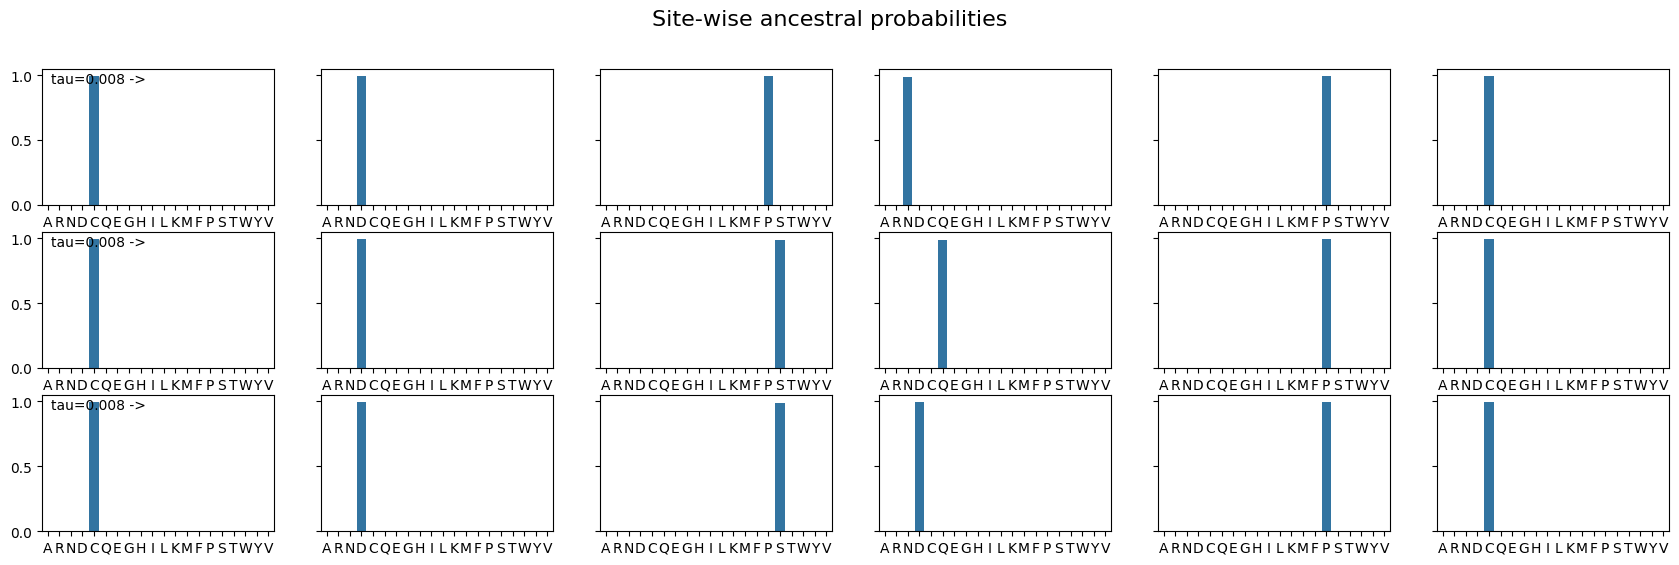

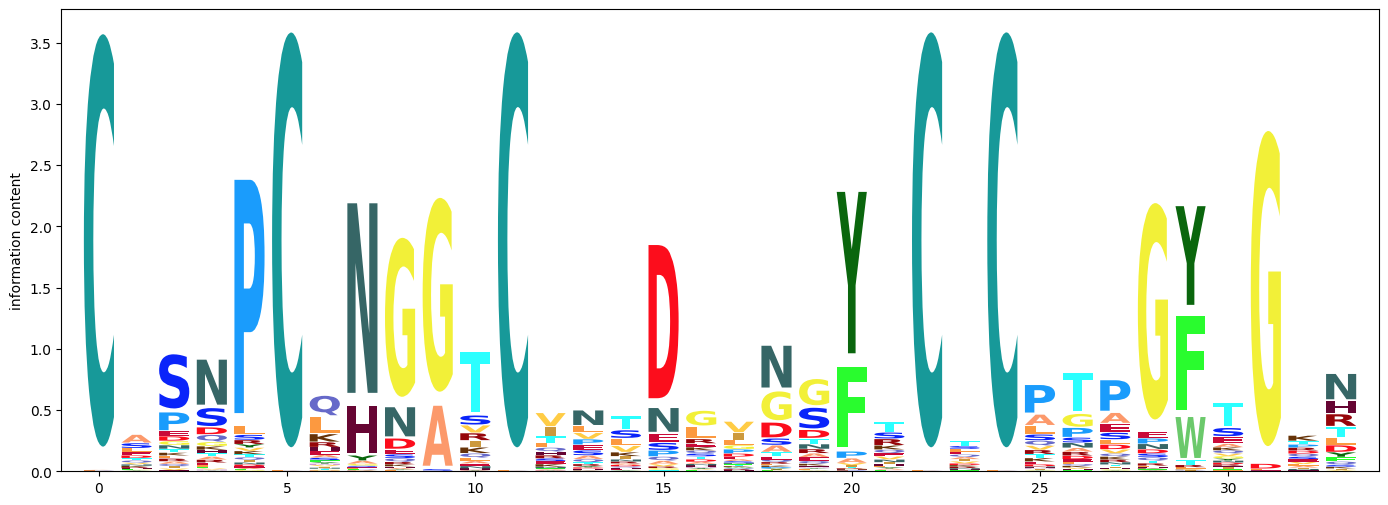

In [6]:
out_filename = "test/data/interactive.alignment.fasta"
config = Configuration.make_default(num_models)
with SequenceDataset(train_filename, fmt="fasta") as data:
    config["crop_long_seqs"] = int(np.ceil(2 * np.mean(data.seq_lens))) #comment out to disable cropping
    alignment_model = Align.run_learnMSA(data,
                                        out_filename,
                                        config, 
                                        sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]) 
                                            if use_weights else None,
                                        verbose=True,
                                        align_insertions=align_insertions)
    Visualize.print_and_plot(alignment_model, alignment_model.best_model)

The following optional cells compare the alignment against a reference and require t-coffee to be installed. 

In [2]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [3]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    73.7 [100.0]   [ 5182]
